In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
from numpy import random
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

from pathlib import Path
home = str(Path.home())
base_path = os.path.join(home, 'workspace/multiLID/data/extract/run_1/')

In [2]:
NR_SAMPLES = 2000

In [3]:
nor_fgsm = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/fgsm/k20/lid_normalos_8255.pt'))[:NR_SAMPLES]
adv_fgsm = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/fgsm/k20/lid_adverlos_8255.pt'))[:NR_SAMPLES]
nor_bim  = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/bim/k20/lid_normalos_8255.pt'))[:NR_SAMPLES]
adv_bim  = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/bim/k20/lid_adverlos_8255.pt'))[:NR_SAMPLES]
nor_pgd  = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/pgd/k20/lid_normalos_8255.pt'))[:NR_SAMPLES]
adv_pgd  = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/pgd/k20/lid_adverlos_8255.pt'))[:NR_SAMPLES]
nor_aa   = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/aa/k20/lid_normalos_8255.pt'))[:NR_SAMPLES]
adv_aa   = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/aa/k20/lid_adverlos_8255.pt'))[:NR_SAMPLES]
nor_df   = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/df/k20/lid_normalos.pt'))[:NR_SAMPLES]
adv_df   = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/df/k20/lid_adverlos.pt'))[:NR_SAMPLES]
nor_cw   = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/cw/k20/lid_normalos.pt'))[:NR_SAMPLES]
adv_cw   = torch.load(os.path.join(base_path, 'cifar10/wrn28-10/lid/cw/k20/lid_adverlos.pt'))[:NR_SAMPLES]

In [4]:
nor = [nor_fgsm, nor_bim, nor_pgd, nor_aa, nor_df, nor_cw,]
adv = [adv_fgsm, adv_bim, adv_pgd, adv_aa, adv_df, adv_cw,]

In [5]:
np.ones(nor_fgsm.shape[0]).astype('int').shape

(100,)

In [6]:
attacks = ['fgsm', 'bim', 'pgd', 'aa', 'df', 'cw']
labels  = ['FGSM', 'BIM', 'PGD', 'AA', 'DF', 'CW']
#cdict  = {0: 'black', 1: 'pink', 2: 'blue', 3: 'red', 4: 'green', 5: 'cyan', 6: 'orange', 7: 'purple'}
cdict  = {'FGSM': 'blue', 'BIM': 'red', 'PGD': 'gree', 'AA': 'cyan', 'DF': 'orange', 'CW': 'purple'}

factor = 0.8
nr_mean = 1
mean_tables = []
nr_samples=2000

importances_list = {}

for it in range(nr_mean):
    random_state = 21 # random.randint(100)
    print("random state: ", random_state)
    final_table = np.zeros((len(nor), len(adv)))

    for i, rows in enumerate(range(len(nor))):
        X_nor = nor[rows]
        X_adv = adv[rows]
        if len(X_nor.shape) > 2: 
            X_nor = nor[rows].reshape((nor[rows].shape[0], -1))[:,::-1]
            X_adv = adv[rows].reshape((adv[rows].shape[0], -1))[:,::-1]
                
        y_nor = np.zeros(X_nor.shape[0]).astype('int')
        y_adv = np.ones(X_nor.shape[0]).astype('int')
        
        x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(X_nor, y_nor, test_size=1-factor, train_size=factor, random_state=random_state)
        x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(X_adv, y_adv, test_size=1-factor, train_size=factor, random_state=random_state)

        X_train = np.concatenate((x_train_n, x_train_a))
        y_train = np.concatenate((y_train_n, y_train_a))
                
        clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
        
        clf.fit(X_train, y_train)
        importances = clf.feature_importances_
        importances_list[labels[i]]  = importances

random state:  21


In [7]:
importances_list

{'FGSM': array([0.04812599, 0.07909952, 0.07039104, 0.26130188, 0.06032364,
        0.03738013, 0.02329828, 0.01902603, 0.05164149, 0.05531921,
        0.02316352, 0.10889712, 0.16203215]),
 'BIM': array([0.04510673, 0.05253479, 0.04379196, 0.16283092, 0.10195306,
        0.05808764, 0.04335598, 0.05004729, 0.04648265, 0.04496367,
        0.06386534, 0.10032633, 0.18665365]),
 'PGD': array([0.03724166, 0.04252836, 0.03775719, 0.14566497, 0.08944221,
        0.04816506, 0.03335176, 0.03530542, 0.03636089, 0.04024311,
        0.0602539 , 0.11999746, 0.27368802]),
 'AA': array([0.02111938, 0.026423  , 0.02000831, 0.10815503, 0.09381758,
        0.03800345, 0.02751369, 0.01919334, 0.04125167, 0.02282126,
        0.04617919, 0.15925138, 0.37626274]),
 'DF': array([0.02301886, 0.02215051, 0.02377981, 0.02815492, 0.02878017,
        0.02566668, 0.02354187, 0.02640675, 0.0245405 , 0.02894847,
        0.04921339, 0.21109053, 0.48470754]),
 'CW': array([0.0275344 , 0.02714873, 0.02518557, 0.0290

In [8]:
df = pd.DataFrame.from_dict(importances_list)
cdict  = {'FGSM': 'blue', 'BIM': 'red', 'PGD': 'green', 'AA': 'cyan', 'DF': 'orange', 'CW': 'purple'}

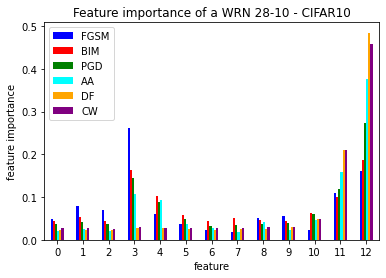

In [10]:
plot = df.plot(kind='bar', color=cdict, title="Feature importance of a WRN 28-10 - CIFAR10", ylabel="feature importance", xlabel="feature", rot=0)
fig = plot.get_figure()
fig.savefig( 'plots/' + 'feature_importance/' + 'cifar10_wrn2810_k10.png', bbox_inches='tight', dpi=600)